# Advanced Chunking for RAG
* Notebook by Adam Lang
* Date: 1/24/2025

# Overview
* In this notebook we will go over advanced chunking strategies related to Semantic Chunking for Retrieval Augmented Generation.

# Install Dependencies

In [1]:
%%capture
!pip install -U\
semantic-router==0.0.37\
pinecone-client==3.1.0\
datasets==2.19.0

In [7]:
## imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## ML imports
import torch
import transformers
from datasets import load_dataset, Dataset, DatasetDict
import semantic_router

# Load Dataset from Hugging Face
* Dataset: `jamescalam/ai-arxiv`
* dataset card: https://huggingface.co/datasets/jamescalam/ai-arxiv

In [5]:
## load dataset from HF
dataset = load_dataset('jamescalam/ai-arxiv', split="train")
dataset

Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/423 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'summary', 'source', 'authors', 'categories', 'comment', 'journal_ref', 'primary_category', 'published', 'updated', 'content', 'references'],
    num_rows: 423
})

# Initiate Encoder from OpenAI
* We will use the OpenAI embeddings.

In [9]:
import os
from getpass import getpass
from semantic_router.encoders import OpenAIEncoder

In [10]:
## create environment
OPENAI_API_KEY = getpass("Enter your OPENAI API KEY: ")

Enter your OPENAI API KEY: ··········


In [11]:
## create env
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

In [12]:
## setup encoder
encoder = OpenAIEncoder(name="text-embedding-3-small")
encoder

OpenAIEncoder(name='text-embedding-3-small', score_threshold=0.82, type='openai', client=<openai.OpenAI object at 0x7f438cc726d0>, dimensions=NOT_GIVEN, token_limit=8192)

In [15]:
## view dataset
print(dataset['content'][1])

Published as a conference paper at ICLR 2019
DECOUPLED WEIGHT DECAY REGULARIZATION
Ilya Loshchilov & Frank Hutter
University of Freiburg
Freiburg, Germany,
filya,fhg@cs.uni-freiburg.de
ABSTRACT
L2regularization and weight decay regularization are equivalent for standard
stochastic gradient descent (when rescaled by the learning rate), but as we demon-
strate this is notthe case for adaptive gradient algorithms, such as Adam. While
common implementations of these algorithms employ L 2regularization (often
calling it “weight decay” in what may be misleading due to the inequivalence we
expose), we propose a simple modiﬁcation to recover the original formulation of
weight decay regularization by decoupling the weight decay from the optimization
steps taken w.r.t. the loss function. We provide empirical evidence that our pro-
posed modiﬁcation (i) decouples the optimal choice of weight decay factor from
the setting of the learning rate for both standard SGD and Adam and (ii) substan-
tially

## Rolling Window Splitter
* Divides the document into sentences and evaluates similarity between them, concatenating based on a specified window.
* This splitter can determine the optimal similarity threshold for concatenation or new chunk generation.

In [29]:
from semantic_router.splitters import RollingWindowSplitter
from semantic_router.utils.logger import logger

## reduce logs from splitter
logger.setLevel("WARNING")

## set score_threshold
#encoder.score_threshold=0.22

# init splitter
splitter = RollingWindowSplitter(
    encoder=encoder,
    dynamic_threshold=False, ##
    min_split_tokens=100, # min of 100 tokens
    max_split_tokens=500, # max of 500 tokens
    window_size=2, # default is 5
    plot_splits=True, ## set to True to visualize chunking
    enable_statistics=True, # pring chunking statistics!

)

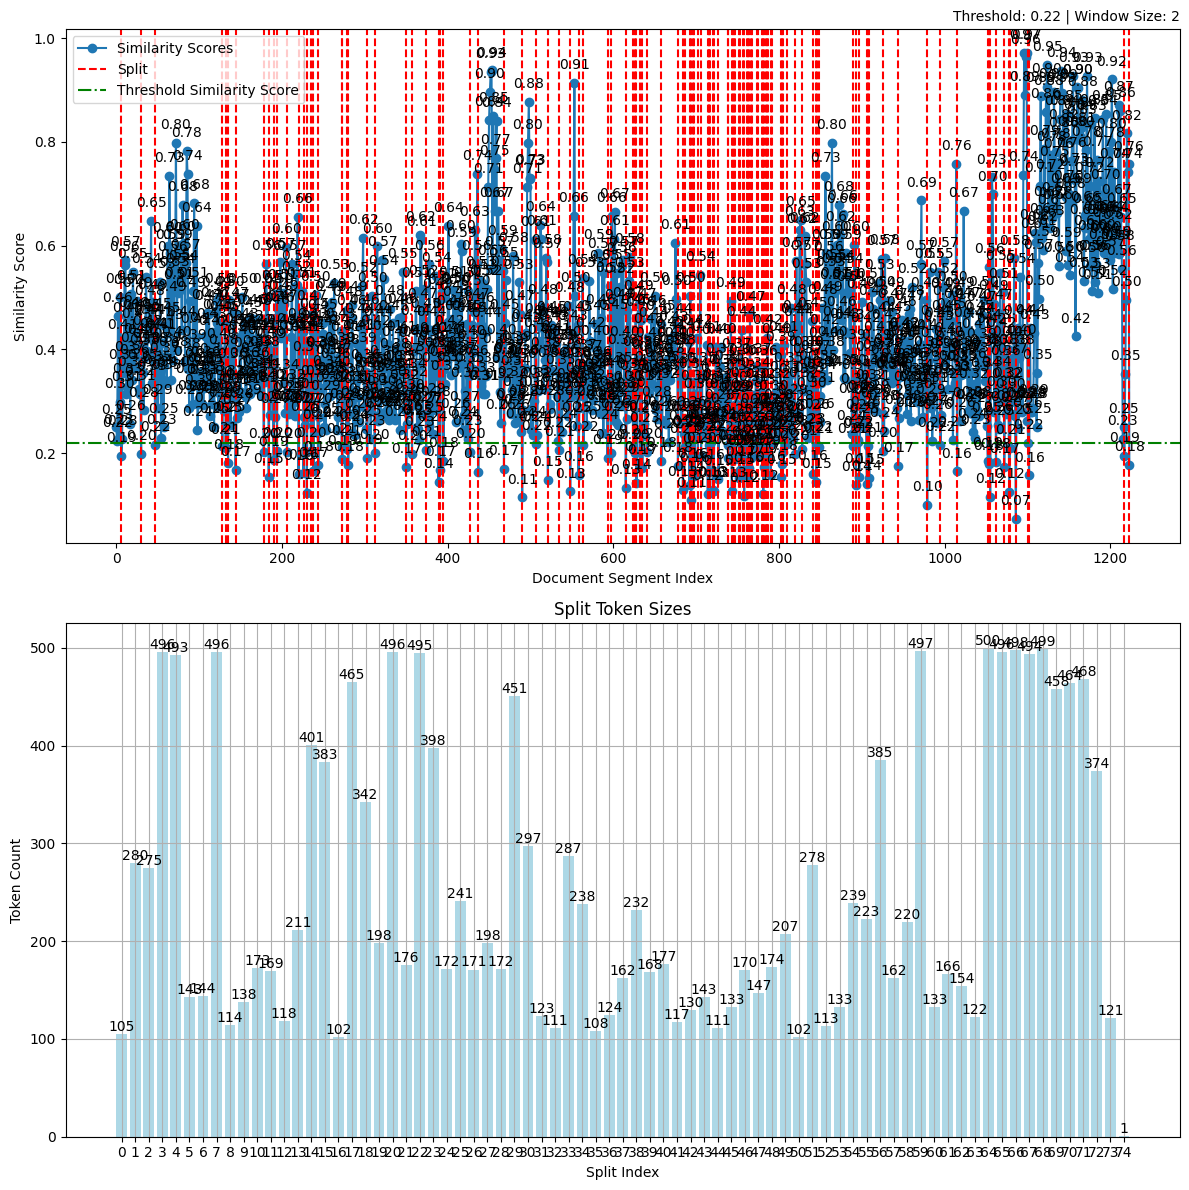

Splitting Statistics:
  - Total Documents: 1225
  - Total Splits: 75
  - Splits by Threshold: 60
  - Splits by Max Chunk Size: 14
  - Last Split: 1
  - Minimum Token Size of Split: 1
  - Maximum Token Size of Split: 500
  - Similarity Split Ratio: 0.80


In [30]:
## create splits
splits = splitter([dataset['content'][0]])

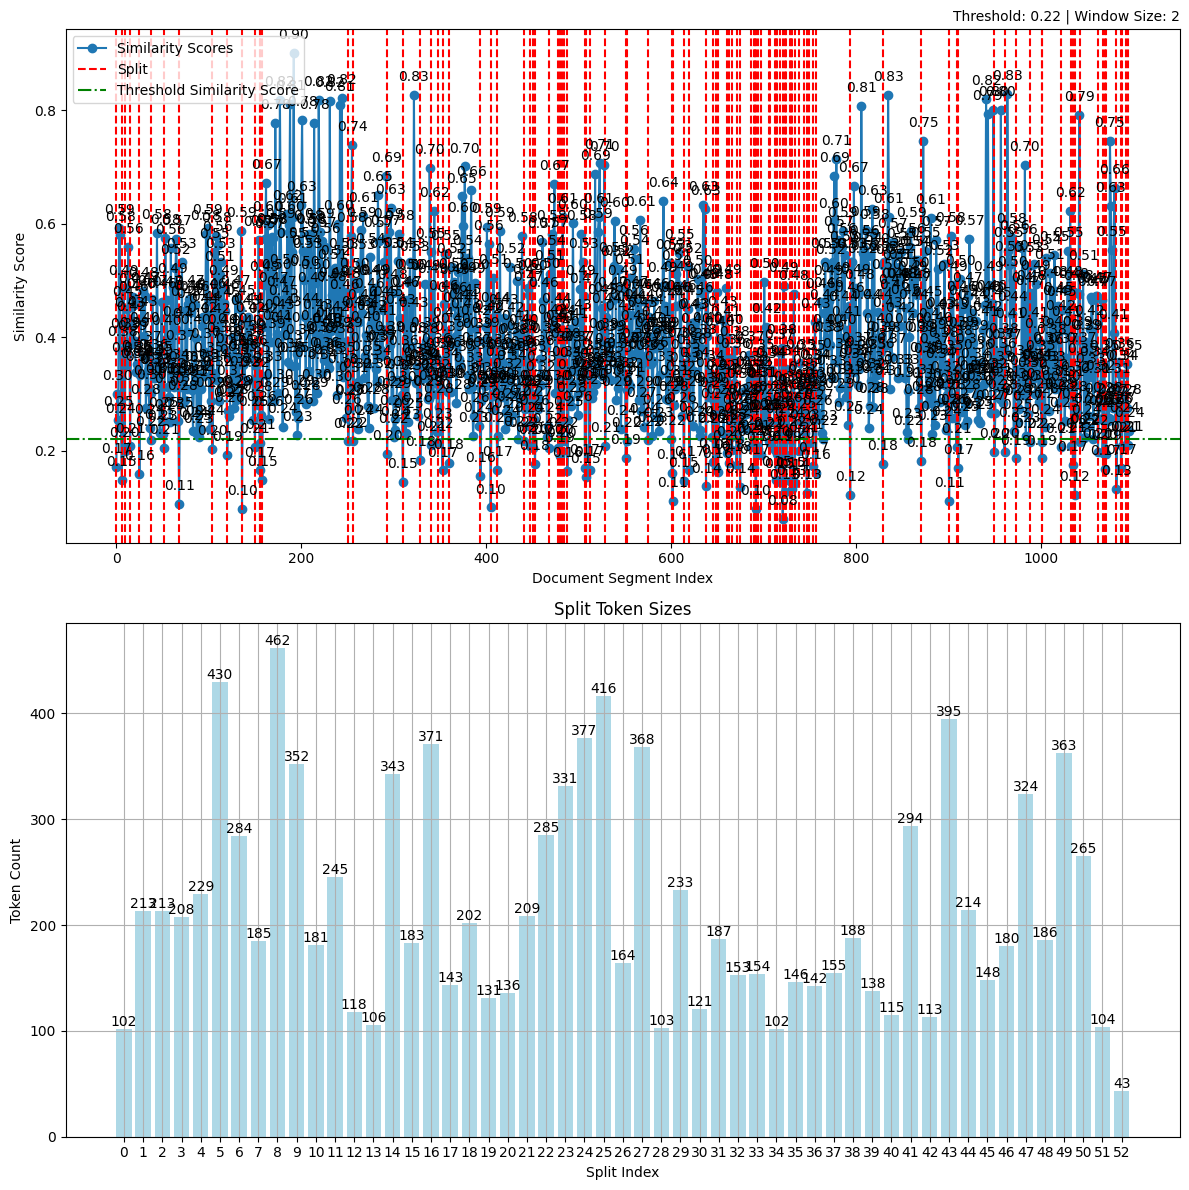

Splitting Statistics:
  - Total Documents: 1098
  - Total Splits: 53
  - Splits by Threshold: 52
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 43
  - Maximum Token Size of Split: 462
  - Similarity Split Ratio: 0.98


In [31]:
splits = splitter([dataset['content'][1]])

/usr/local/lib/python3.11/dist-packages/semantic_router/splitters/rolling_window.py:410: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


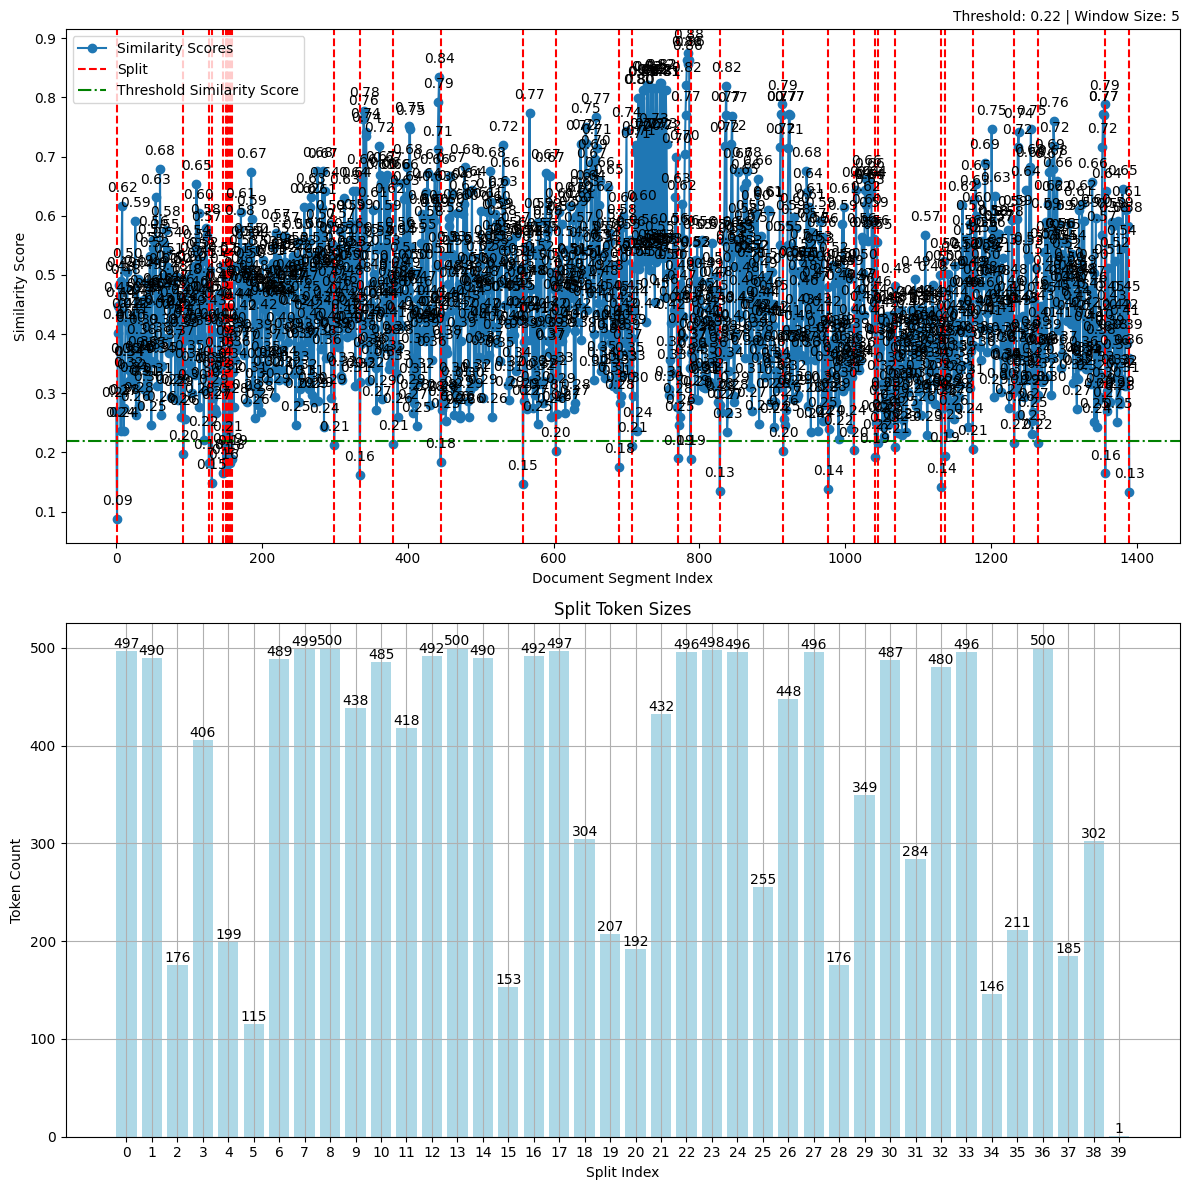

Splitting Statistics:
  - Total Documents: 1392
  - Total Splits: 40
  - Splits by Threshold: 22
  - Splits by Max Chunk Size: 17
  - Last Split: 1
  - Minimum Token Size of Split: 1
  - Maximum Token Size of Split: 500
  - Similarity Split Ratio: 0.55


In [28]:
splits = splitter([dataset['content'][2]])

Summary

* We can see the documents were each split based on the similarity scores at the RED lines.
* We can see the red lines get closer when there isn't that much similarity between documents -- the closer red lines may be the references in the arxiv papers which are not that

**Note about Splitting Statistics**
* You want more **Splits by Threshold**. The more Splits by Threshold you have than Splits by Max Chunk Size, the better your semantic chunks will be!
* We can see in the example just above, there are 66 splits by threshold to 4 max splits.
  * You can increase your chunk sizes or you can set a threshold.
  * You can also change the `window_size` as well.


In [32]:
## view splits
splitter.print(splits[:3])

Split 1, tokens 102, triggered by: 0.20
Published as a conference paper at ICLR 2019 DECOUPLED WEIGHT DECAY REGULARIZATION Ilya Loshchilov & Frank Hutter University of Freiburg Freiburg, Germany, filya,fhg@cs.uni-freiburg.de ABSTRACT L2regularization and weight decay regularization are equivalent for standard stochastic gradient descent (when rescaled by the learning rate), but as we demon- strate this is notthe case for adaptive gradient algorithms, such as Adam.
----------------------------------------------------------------------------------------


Split 2, tokens 213, triggered by: 0.16
While common implementations of these algorithms employ L 2regularization (often calling it “weight decay” in what may be misleading due to the inequivalence we expose), we propose a simple modiﬁcation to recover the original formulation of weight decay regularization by decoupling the weight decay from the optimization steps taken w.r.t. the loss function. We provide empirical evidence that our p

In [33]:
## viewing the objects
splits[:3]

[DocumentSplit(docs=['Published as a conference paper at ICLR 2019', 'DECOUPLED WEIGHT DECAY REGULARIZATION', 'Ilya Loshchilov & Frank Hutter', 'University of Freiburg', 'Freiburg, Germany,', 'filya,fhg@cs.uni-freiburg.de', 'ABSTRACT', 'L2regularization and weight decay regularization are equivalent for standard', 'stochastic gradient descent (when rescaled by the learning rate), but as we demon-', 'strate this is notthe case for adaptive gradient algorithms, such as Adam.'], is_triggered=True, triggered_score=0.19968332793515436, token_count=102, metadata=None),
 DocumentSplit(docs=['While', 'common implementations of these algorithms employ L 2regularization (often', 'calling it “weight decay” in what may be misleading due to the inequivalence we', 'expose), we propose a simple modiﬁcation to recover the original formulation of', 'weight decay regularization by decoupling the weight decay from the optimization', 'steps taken w.r.t. the loss function.', 'We provide empirical evidence 

In [34]:
## now we can see the chunks separated into a list of sentence-like strings.
## to output chunks from this we use .content attribute
splits[0].content

'Published as a conference paper at ICLR 2019 DECOUPLED WEIGHT DECAY REGULARIZATION Ilya Loshchilov & Frank Hutter University of Freiburg Freiburg, Germany, filya,fhg@cs.uni-freiburg.de ABSTRACT L2regularization and weight decay regularization are equivalent for standard stochastic gradient descent (when rescaled by the learning rate), but as we demon- strate this is notthe case for adaptive gradient algorithms, such as Adam.'

## Adding Contextual Information to Chunks
* Creating embeddings we often want to include contextual information to improve retrieval in RAG.
* **A simple method is to prefix titles or headers to each chunk.**
  * **This is a great way to add METADATA to structured documents like PDFs.**


In [35]:
##function for contextual metadata
def context_chunks(title: str, content: str):
  return f"# {title}\n{content}"

## applying function
title = dataset[2]["title"]
for i in splits[:3]:
  print("---")
  print(context_chunks(title=title, content=i.content))

---
# The Curse of Recursion: Training on Generated Data Makes Models Forget
Published as a conference paper at ICLR 2019 DECOUPLED WEIGHT DECAY REGULARIZATION Ilya Loshchilov & Frank Hutter University of Freiburg Freiburg, Germany, filya,fhg@cs.uni-freiburg.de ABSTRACT L2regularization and weight decay regularization are equivalent for standard stochastic gradient descent (when rescaled by the learning rate), but as we demon- strate this is notthe case for adaptive gradient algorithms, such as Adam.
---
# The Curse of Recursion: Training on Generated Data Makes Models Forget
While common implementations of these algorithms employ L 2regularization (often calling it “weight decay” in what may be misleading due to the inequivalence we expose), we propose a simple modiﬁcation to recover the original formulation of weight decay regularization by decoupling the weight decay from the optimization steps taken w.r.t. the loss function. We provide empirical evidence that our pro- posed modiﬁca

### Summary
* The contextual chunks above we feed to the embedding models as "context" but NOT TO THE LLM.
* So we give the `title` and `content` fields to the embedding model as metadata so that during the retrieval process we can format them in a way that makes the most sense for better retrieval.

....Another approach that is worth considering is to bring in **contextual information from surrounding chunks** for the LLM
  * To do this we need to track before and after chunks which we place in 2 new metadata fields:
    * 1. **prechunk**
    * 2. **postchunk**

....Still another method to try is to allow for **connections between documents.**
  * To to do this we can add a field named `arxiv_id` that identifies this paper.
  * We can also add a `references` field that includes other paper's `arxiv_id` that were references in the paper.

In [37]:
## add connections between documents
arxiv_id = dataset[2]["id"]
refs = dataset[2]['references']

## add prechunk and postchunk metadata
metadata = []
for i, s in enumerate(splits[:3]):
  prechunk = "" if i == 0 else splits[i-1].content
  postchunk = "" if i-1 == len(splits) else splits[i+1].content
  metadata.append({
      "title": title,
      "content": s.content,
      "prechunk": prechunk,
      "postchunk": postchunk,
      "arxiv_id": arxiv_id,
      "references": refs,
  })

In [38]:
## view index 0 of metadata
metadata[0]

{'title': 'The Curse of Recursion: Training on Generated Data Makes Models Forget',
 'content': 'Published as a conference paper at ICLR 2019 DECOUPLED WEIGHT DECAY REGULARIZATION Ilya Loshchilov & Frank Hutter University of Freiburg Freiburg, Germany, filya,fhg@cs.uni-freiburg.de ABSTRACT L2regularization and weight decay regularization are equivalent for standard stochastic gradient descent (when rescaled by the learning rate), but as we demon- strate this is notthe case for adaptive gradient algorithms, such as Adam.',
 'prechunk': '',
 'postchunk': 'While common implementations of these algorithms employ L 2regularization (often calling it “weight decay” in what may be misleading due to the inequivalence we expose), we propose a simple modiﬁcation to recover the original formulation of weight decay regularization by decoupling the weight decay from the optimization steps taken w.r.t. the loss function. We provide empirical evidence that our pro- posed modiﬁcation (i) decouples the 

### Summary
* We can now see the prechunk and postchunk metadata that was added to this chunk above.

## Add ids is another method for metadata management

In [39]:
from semantic_router.schema import DocumentSplit

In [42]:
## function to build metadata when you have a large set of documents!!

def get_metadata(doc: dict, doc_splits: list[DocumentSplit]):
  # get document level metadata first
  arxiv_id = doc["id"]
  title = doc["title"]
  refs = doc['references']
  # init split level metadata list
  metadata = []
  for i, split in enumerate(doc_splits):
    # get neighboring semantic chunks
    prechunk_id = "" if i == 0 else f"{arxiv_id}#{i-1}"
    postchunk_id = "" if i+1 == len(doc_splits) else f"{arxiv_id}#{i+1}"
    # create dict and append to metadata list
    metadata.append({
        "id": f"{arxiv_id}#{i}",
        "title": title,
        "content": split.content,
        "prechunk_id": prechunk_id,
        "postchunk_id": postchunk_id,
        "arxiv_id": arxiv_id,
        "references": refs,
    })
  return metadata

In [43]:
## create metadata
metadata = get_metadata(
    doc=dataset[2],
    doc_splits=splits[:3],
)

## view metadata
metadata

[{'id': '2305.17493#0',
  'title': 'The Curse of Recursion: Training on Generated Data Makes Models Forget',
  'content': 'Published as a conference paper at ICLR 2019 DECOUPLED WEIGHT DECAY REGULARIZATION Ilya Loshchilov & Frank Hutter University of Freiburg Freiburg, Germany, filya,fhg@cs.uni-freiburg.de ABSTRACT L2regularization and weight decay regularization are equivalent for standard stochastic gradient descent (when rescaled by the learning rate), but as we demon- strate this is notthe case for adaptive gradient algorithms, such as Adam.',
  'prechunk_id': '',
  'postchunk_id': '2305.17493#1',
  'arxiv_id': '2305.17493',
  'references': [{'id': '1906.02243'},
   {'id': '1810.04805'},
   {'id': '2305.17493'},
   {'id': '2302.10149'},
   {'id': '2205.01068'},
   {'id': '1907.11692'},
   {'id': '2106.09667'},
   {'id': '1708.06733'},
   {'id': '1904.07734'}]},
 {'id': '2305.17493#1',
  'title': 'The Curse of Recursion: Training on Generated Data Makes Models Forget',
  'content': 

### Summary
* Now when giving this structure to the LLM we will be able to change the format and how much information we provide and how we handle the connected documents.
* This info will help us later during the generative outputs.


# Indexing Data into Vector Database
* After chunking we want to index each chunk with its metadata in our vector store a vector database.

In [44]:
from pinecone import Pinecone

In [51]:
## connect to pinecone client
PINECONE_API_KEY = getpass("Enter your pinecone api key: ")

Enter your pinecone api key: ··········


In [52]:
## setup env
pc = Pinecone(api_key=PINECONE_API_KEY)

Set the index specification to define cloud provider and region to deploy the index in Pinecone

In [53]:
from pinecone import ServerlessSpec

## init spec
spec = ServerlessSpec(
    cloud="aws",
    region="us-east-1",
)

Prior to creating an index, we need to get the dimensionality of the OpenAI embedding model we are using.
  * We can embed a text example and measure the vector dimensions.

In [54]:
## get vector dimensions
dimensions = len(encoder(["random text here"])[0])
dimensions

1536

Great we can see the dimensionality of the embedding model we are using is `1536`.

Next we do this:

1. create the vector index using this embedding dimensionality

2. Use a metric compatible with the model (e.g. cosine or dotproduct)

3. We pass the pinecone spec to index init.

In [55]:
import time

## set index
index_name = "advanced-rag-chunking"

## check if index already exists
if index_name not in pc.list_indexes().names():
  # if does not exist then create index
  pc.create_index(
      index_name,
      dimension=dimensions, # dimensionality of embed 3 from open ai
      metric='dotproduct', ## can also use "cosine" or "euclidean distance"
      spec=spec,
  )
  # wait for index to be init
  while not pc.describe_index(index_name).status['ready']:
    time.sleep(1)

## connect to index
index = pc.Index(index_name)
time.sleep(1)

## view index statistics
index.describe_index_stats()


{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [57]:
from tqdm.auto import tqdm

## cutdown dataset
data = dataset.to_pandas().iloc[:5000]
# store dataset without embeddings
full_dataset = []

batch_size = 128

# adjust splitter to not display stats and visuals
splitter.enable_statistics = False
splitter.plot_splits = False

for doc in tqdm(dataset):
  # splits
  splits = splitter([doc['content']])
  # create IDs and metadata for all splits in doc
  metadata = get_metadata(doc=doc, doc_splits=splits)
  for i in range(0, len(splits), batch_size):
    i_end = min(len(splits), i+batch_size)
    # get batch of data
    metadata_batch = metadata[i:i_end]
    full_dataset.extend(metadata_batch)
    # generate unique ids for each chunk
    ids = [m['id'] for m in metadata_batch]
    # get text content to embed
    content = [
        context_chunks(
            title=x['title'], content=x['content']
        ) for x in metadata_batch
    ]
    # embed text
    embeds = encoder(content)
    # Modify metadata for Pinecone compatibility
    modified_metadata_batch = [{k: v for k, v in m.items() if k != 'references'} for m in metadata_batch] # removing 'references' field
    # add to Pinecone with modified metadata
    index.upsert(vectors=zip(ids, embeds, modified_metadata_batch)) # using modified metadata

  0%|          | 0/423 [00:00<?, ?it/s]

# RAG queries to Pinecone
* Now lets test out the functionality.

In [60]:
## function to query
def query(text: str):
  ## create query vector
  query_vec = encoder([text])[0]
  matches = index.query(
      vector=query_vec,
      top_k=2,
      include_metadata=True,
  )
  ## iterate through queries and return metadata
  chunks = []
  for m in matches['matches']:
    content = m['metadata']['content']
    title = m['metadata']['title']
    pre_chunk = m['metadata']['prechunk_id']
    post_chunk = m['metadata']['postchunk_id']
    # Fix: Access fetched results directly using id
    other_chunks = index.fetch(ids=[pre_chunk, post_chunk])
    ## pre chunks and post chunks
    # Fix: Use correct key to access metadata
    prechunk = other_chunks[pre_chunk]['metadata']['content'] if pre_chunk in other_chunks else "" # Handle case where pre_chunk might not exist
    postchunk = other_chunks[post_chunk]['metadata']['content'] if post_chunk in other_chunks else "" # Handle case where post_chunk might not exist
    chunk = f"""# {title}

    {prechunk[-400:]}
    {content}
    {postchunk[:400]}"""
    chunks.append(chunk)

  return chunks

We will query the vector store in Pinecone and return the metadata with each "hit" that we get in our top_k.

In [62]:
## apply query function and look at metadata
query("What are large language models?")

['# Large Language Models Are Human-Level Prompt Engineers\n\n    \n    Language models are few-shot learners. Advances in neural information processing systems , 33:1877–1901, 2020. Mark Chen, Jerry Tworek, Heewoo Jun, Qiming Yuan, Henrique Ponde de Oliveira Pinto, Jared Kaplan, Harri Edwards, Yuri Burda, Nicholas Joseph, Greg Brockman, et al. Evaluating large language models trained on code. arXiv preprint arXiv:2107.03374 , 2021. Karl Cobbe, Vineet Kosaraju, Mohammad Bavarian, Jacob Hilton, Reiichiro Nakano, Christopher Hesse, and John Schulman.\n    ',
 '# Large Language Models Are Human-Level Prompt Engineers\n\n    \n    Aarohi Srivastava, Abhinav Rastogi, Abhishek Rao, Abu Awal Md Shoeb, Abubakar Abid, Adam Fisch, Adam R Brown, Adam Santoro, Aditya Gupta, Adrià Garriga-Alonso, et al. Beyond the imitation game: Quantifying and extrapolating the capabilities of language models. arXiv preprint arXiv:2206.04615 , 2022. Mirac Suzgun, Nathan Scales, Nathanael Schärli, Sebastian Gehrma